# The Non Random Two Liquids (NRTL) model for *excess Gibbs energy* ($g^E$) and a case study of Liquid-Liquid equilibria of Ethyl acetate (1) + water (2) + ethanol (3)

Having previously discussed *Excess thermodynamic properties*, excess Gibbs energy *models*, the NRTL model specifically, and VLE, we now proceed to study LLE.

# Requiremens
As usually we start by gathering in the initial cells any packages what we shall use in the current notebook.

## The NumPy package
for array structures and operations

In [1]:
import numpy as np

## The pyplot interface from the matplotlib package
for generating plots

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

## physical constants in the international system of units from the scipy package

In [3]:
from scipy.constants import R

# print it to check its value
print('R = ',R,'J.mol⁻1.K⁻1')

R =  8.3144598 J.mol⁻1.K⁻1


# The NRTL model
as presented in previous lecture, is reproduced below in a minimalist numpy/numba format

In [4]:
from numba import jit
@jit
def Gamma(T,c_x,q_alpha, q_A):
    q_tau     = q_A/T
    q_G       = np.exp(-(q_alpha*q_tau))
    l_D       = ((1/((q_G.T) @ c_x)).T)
    q_E       = (q_tau*q_G) * l_D 
    gamma     = np.exp(((q_E+(q_E.T))-(((q_G * l_D) * (c_x.T)) @ (q_E.T))) @ c_x)
    return gamma

# System target of this case study
Ethyl acetate (1) + water (2) + ethanol (3)


In [5]:
# Ethyl acetate (1) + water (2) + ethanol (3)

# some identification variables
# which integer index shall correspond to which component here
i_EA = 0
i_W = 1
i_E = 2

# name of the components of the system in a format suitable for labeling of the plots
compNames = ['ethyl acetate', 'water', 'ethanol']


# Fitted parameters
from Renon and Prausnitz, 1969.

In [6]:
# 3 binary aĺpha parameters

alpha12 = 0.4

alpha23 = 0.3

alpha13 = 0.3

# 6 binary Dgij parameters
Dg12 = 1335 * 4.184 #J/K
Dg21 = 2510 * 4.184 #J/K

Dg23 = 976 * 4.184 #J/K
Dg32 = 88 * 4.184 #J/K

Dg13 = 301 * 4.184 #J/K
Dg31 = 322 * 4.184 #J/K

## Feeding the fitted parameters to the model in matrix structure:
we will assemble the parameters in a matrix structure compatible with the current imlementation of the model

In [7]:
#assemble matrix with regressed parameters Dg_i,j, according to the model all diagonal terms are zero
Dg = np.array([[0, Dg12, Dg13],
             [Dg21, 0, Dg23],
             [Dg31, Dg32, 0]])


#assemble symmetric matrix alpha
alpha = np.array([[0, alpha12, alpha13],
                [alpha12, 0, alpha23],
                [alpha13, alpha23, 0]])

A= Dg/R

## Thermodynamic condition for the system target of the case study
* ELL equilibria at constant temperature of 70 °C and constant atmospheric pressure
* Varying in phases composition, overall composition and relative amount of phases

In [8]:
T = 273+70 #K

# Liq-Liq Equilibria Flash
Now we start discussing the Liq-Liq equilibria flash calculation

it works as follows:

The degrees of Freedom for a flash calculation are temperature - T, pressure - P and global composition - z

<img src=supportFiles/algorithms.png width=500>

**Equilibriuma criteria**

$$\mu_{i}^{\rm {L1}}=\mu_{i}^{\rm {L2}}, \forall i$$

**derived criteria after analytical simplification of repeated contributions:**

$$x_{i}^{\rm {L1}} \gamma_{i}^{\rm {L1}}= x_{i}^{\rm {L2}} \gamma_{i}^{\rm {L2}}, \forall i$$

**Devised algorithm**

based on Rachford and Rice
successive substitution (fixed point search) of K,XI,XII,beta meeting the following criteria

|*variables* | number |
| :-: | :-: |
| $K$ | (C) |
| $\gamma^{I}, \gamma^{II}$ | (2C) |
| $x^{I}, x^{II}$ | (2C) |
| $\beta$ | (1) |
| **total** | **(5C+1)** |

| - - - - - - - - - - - - - - - - *equations* - - - - - - - - - - - - - - - - | number |
| :-: | :-: |
| $K(\gamma^{I},\gamma^{II})=\gamma^I/\gamma^{II}$ | (C) |
| $\gamma=f^{\gamma}(x)$ | (2C) |
| $x^I(\beta,K)=$ | (C) |
| $x^{II}(K,x^I)=Kx^I$ | (C) |
| $F(\beta ,K)= \sum_i \left[ \frac{z_i(K_i-1)} {1+ \beta (K_i-1)} \right]=0$ | (1) |
| **total** | **(5C+1)** |

## A closure for the model

Noticing how the recursive use of the model is to be performed:
* the model is a function of T, x, alpha and A
* T is constant throughout all calculations of interest in this notebook
* the parameters matrix alpha and A depend on the components present in the system and a indexing order specified, however not on specific composition
---
* we could use with convenience a model implementation tha provides gamma as a function of x at constant pre-specified T alpha and A

we will use th lambda function to create that convenient interface implementation form the previously implemented model.

In [9]:
#using the lambda function, create a closure defining the model NRTL with constant T and paramters for the algorithm to work with.
MODEL = lambda x: Gamma(T,x,alpha,A)

# The algorithm
based on Rachford and Rice (1952) approach to LV equilibrium


Ref: Rachford HH, Rice JD, Petroleum Trans AIME 1952;195:327-328

## explicit implementation
first we provide an explicit (regarding the loops through the lists of comps and phases) implementation

* note how the 4th argument is MODEL, which shall match a function of one variable, correspondig to the model for gamma as a function of x under study.

In [10]:
def ELLflash_explicit(Z,beta0,K0,MODEL,qolog):
    
    #copy intial guesses to local variables
    beta=beta0.copy() #we use the '.copy()' function to enforce the creation of *copies* and not *views*,
    # so the local variables initially assume the same values of the initial guesse but tehn vary independently
    K=K0.copy()

    converged = 0 # flag indicating convergence, 0 means not converged yet
    
    if qolog: #consider a logical variable to enable or disable the logging of every intermediate step values and reporting it
        itlogi=0
        itlogv=np.ndarray(2,dtype=object)
        itlogv[0]=np.zeros(100*100)
        itlogv[1]=np.zeros([100*100,3])
    
    #initialize local arrays for intemediate values and for results
    a = np.zeros(3)
    XI = np.zeros(3)
    XII = np.zeros(3)
    
    #initialize counters of total number of iterations
    looped2=0
    looped3=0
    
    #managing loop for fixed point point algorithm
    looping2 = 0
    while ( (looping2 == 0) # means do at least once
           or ((ResK)>1e-5 # convergence criteria
               and looping2 < 100) ): # max number of iterations

        # copy k from previous iteration
        prevK = K.copy()
        
        #Solve RachfordRice equation for beta with a newton raphson loop
        looping3 = 0
        while ( (looping3 == 0) # means do at least once
               or ((ResBeta)>1e-5 # convergence criteria
                   and looping3 < 100) ): #max number of iterations
            
            prevbeta = beta.copy()

            for i in range(3):
                a[i] = ( (K[i]-1) / (1+beta*(K[i]-1)) )            
                
            R=0 #residue funtion (F)
            for j in range(3):
                R+=Z[j]*a[j]

            J=0 #jacobian (Fprime)
            for j in range(3):
                J-=Z[j]*a[j]*a[j]
                            
            beta -= R/J #NR step            
            
            if beta[0,0]<0:
                beta[0,0]=0
                
            if 1<beta[0,0]:
                beta[0,0]=1
            
            ResBeta = abs(beta[0,0]-prevbeta[0,0])
            
            looping3 += 1        
            
            if qolog:
                itlogv[0][itlogi] = beta[0,0]
                itlogv[1][itlogi,0:3] = K[0:3,0]
                itlogi += 1
            
        looped3 += looping3

        for i in range(3):
            XI[i] = Z[i] * (1./(1+beta * (K[i]-1))) #Rachford-Rice composition updating scheme
                
        gamaI = MODEL(XI/np.sum(XI)) #enforce normalization in the MODEL call
        
        for i in range(3):
            XII[i] = K[i]*XI[i]

        gamaII = MODEL(XII/np.sum(XII)) #enforce normalization in the MODEL call
        
        for i in range(3):
            K[i] = (gamaI[i])/(gamaII[i]) #definition of K
        
        ResK=0
        for i in range(3):
            ResK += np.sqrt((prevK[i]-K[i])**2)
            
        looping2 += 1
    
    looped2 += looping2
        
    #print('Calculation has ended')
    if (looping2 < 100 and looping3 < 100 and (0.<beta[0,0]<1.) ):
        converged = 1
    
    if qolog: #return results and also iteration log, if asked for
        return XI, XII, beta, converged, looped2, looped3, itlogv
    
    else:
        return XI, XII, beta, converged, looping2, looped3

### using an aproximation of a known solution as initial guess as an easy test for the algorithm
As a intial guess for the solution we can use either 
* a experimentally know values fr the variables in a equilibrium point
* an ad-hoc solution of the model/algorithm

In [11]:
#in our first test we are using the following
#exact ad-hoc NRTL solution
'''at T 343 Z [[ 0.42  0.52  0.06]]
with ig of k0 [[ 0.19681576  7.55695835  1.03698841]] beta0 [[ 0.63972591]]
solution is
xi [ 0.5817747   0.34612964  0.07209566]
xii [ 0.02191985  0.94784403  0.03023612]
beta [[ 0.28895829]]'''

#appproximate solution by truncation
Z_test = np.array([[ 0.42,  0.52,  0.06]]).T
XI_test = np.array([[ 0.58 ,  0.35 , 0.07]]).T
XII_test = np.array([[ 0.02 , 0.95,  0.03]]).T
BETA_test = np.array([[ 0.29]])

# approximate K
K_test=1/(XI_test/XII_test)

#run the algorithm
beta0=BETA_test
k0=K_test
Z=Z_test
ans=ELLflash_explicit(Z,beta0,k0,MODEL,True)

print('at T', T, 'Z', Z_test.T)
print('with ig of k0', K_test.T,'beta0', BETA_test)
print('solution is')
print('xi',ans[0].T)
print('xii',ans[1].T)
print('beta',ans[2])
print('converged?',ans[3], '-- 1 means yes')

at T 343 Z [[ 0.42  0.52  0.06]]
with ig of k0 [[ 0.03448276  2.71428571  0.42857143]] beta0 [[ 0.29]]
solution is
xi [ 0.58176023  0.34614498  0.07209479]
xii [ 0.02191961  0.9478448   0.03023559]
beta [[ 0.28893979]]
converged? 1 -- 1 means yes


# NOTICE THE SIMMETRY

IF WE SWITCH THE INDEX OF THE PHASES L1 (I) <->L2 (II)
* Then the new beta is 1-beta
* the new x1 is x2 and the new x2 is x1,
* then the new k=x2/x1 is old x1/x2, therefore new_K is the old_K^-1


In [12]:
beta0=1-BETA_test
k0=K_test**-1
Z=Z_test

ans=ELLflash_explicit(Z,beta0,k0,MODEL,True)

print('at T', T, 'Z', Z.T)
print('with ig of k0', k0.T,'beta0', beta0)
print('solution is')
print('xi',ans[0].T)
print('xii',ans[1].T)
print('beta',ans[2])
print('converged?',ans[3], '-- 1 means yes')

at T 343 Z [[ 0.42  0.52  0.06]]
with ig of k0 [[ 29.           0.36842105   2.33333333]] beta0 [[ 0.71]]
solution is
xi [ 0.02191969  0.94784455  0.03023576]
xii [ 0.58176493  0.34614     0.07209507]
beta [[ 0.71105421]]
converged? 1 -- 1 means yes


* isn't

>- at T 343 Z [[ 0.42  0.52  0.06]]
>- with ig of k0 [[ 0.03448276  2.71428571  0.42857143]] beta0 [[ 0.29]]
>- solution is
>- xi [ 0.58176023  0.34614498  0.07209479]
>- xii [ 0.02191961  0.9478448   0.03023559]
>- beta [[ 0.28893979]]
>- converged? 1 -- 1 means yes



* the same solution as

>- at T 343 Z [[ 0.42  0.52  0.06]]
>- with ig of k0 [[ 5.08089396  0.13232837  0.96433093]] beta0 [[ 0.36027409]]
>- solution is
>- xi [ 0.02191977  0.94784429  0.03023594]
>- xii [ 0.58176983  0.3461348   0.07209537]
>- beta [[ 0.71104794]]
>- converged? 1 -- 1 means yes




# the mathematical posed system has 2 equivalent solutions, convergence to one or another depends on the initial guess

# the mathematical posed system has also a inifinity of trivial solutions, convergence to that is dependent on initial guess too, when x1==x2==z exactly , k->[1,1,1] exactly, while beta could assume any value and it would not alter the value of our residue functions for there is a K-1 in the numerator

# with one set of initial guesses the problem converges

In [15]:
#we picked an ad-hoc known problematic point here 

beta0=np.array([[.5]])
k0=np.array([[0.1 , 1 , 10]]).T 
Z=Z_test

ans=ELLflash_explicit(Z,beta0,k0,MODEL,True)

print('at T', T, 'Z', Z.T)
print('with ig of k0', k0.T,'beta0', beta0)
print('solution is')
print('xi',ans[0].T)
print('xii',ans[1].T)
print('beta',ans[2])
print('converged?',ans[3], '-- 1 means yes')

at T 343 Z [[ 0.42  0.52  0.06]]
with ig of k0 [[  0.1   1.   10. ]] beta0 [[ 0.5]]
solution is
xi [ 0.58175966  0.34614558  0.07209475]
xii [ 0.0219196   0.94784483  0.03023557]
beta [[ 0.28893906]]
converged? 1 -- 1 means yes


## see the it log

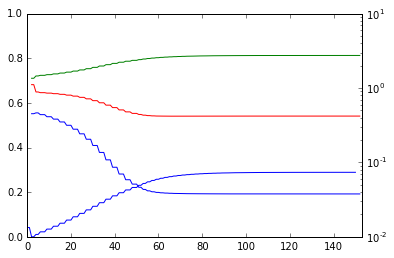

In [16]:
fig1, ax1 = plt.subplots(1,1)
ax1b = ax1.twinx()

xiz=np.arange(ans[5])

ax1.plot(xiz[0:ans[5]-2],(ans[6][0][0:ans[5]-2]))

ax1b.semilogy(xiz[0+2:ans[5]],(ans[6][1][0+2:ans[5],0]))
ax1b.semilogy(xiz[0+2:ans[5]],(ans[6][1][0+2:ans[5],1]))
ax1b.semilogy(xiz[0+2:ans[5]],(ans[6][1][0+2:ans[5],2]))


ax1.set_xlim(0,ans[5])
ax1.set_ylim(0,1)
plt.show()

# however with a dfferent one it does not

In [45]:
beta0=np.array([[.5]])
k0=np.array([[.9 , 1 , 1.1]]).T 
Z=Z_test

ans=ELLflash_explicit(Z,beta0,k0,MODEL,True)

print('at T', T, 'Z', Z.T)
print('with ig of k0', k0.T,'beta0', beta0)
print('solution is')
print('xi',ans[0].T)
print('xii',ans[1].T)
print('beta',ans[2])
print('converged?',ans[3], '-- 1 means yes')

at T 343 Z [[ 0.42  0.52  0.06]]
with ig of k0 [[ 0.9  1.   1.1]] beta0 [[ 0.5]]
solution is
xi [ 0.42  0.52  0.06]
xii [ 0.41973892  0.52026554  0.05999553]
beta [[ 0.]]
converged? 0 -- 1 means yes


# However note,

don't 

>- xi [ 0.42  0.52  0.06]

and

>- xii [ 0.41973892  0.52026554  0.05999553]

 in the solution found
 
 represent the same phase?

## see the it log

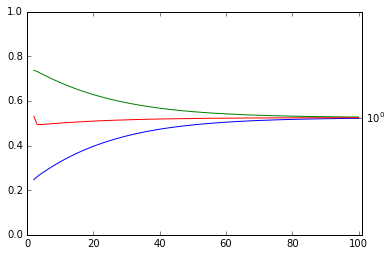

In [46]:
fig1, ax1 = plt.subplots(1,1)
ax1b = ax1.twinx()

xiz=np.arange(ans[5])

ax1.plot(xiz[0:ans[5]-2],(ans[6][0][0:ans[5]-2]))

ax1b.semilogy(xiz[0+2:ans[5]],(ans[6][1][0+2:ans[5],0]))
ax1b.semilogy(xiz[0+2:ans[5]],(ans[6][1][0+2:ans[5],1]))
ax1b.semilogy(xiz[0+2:ans[5]],(ans[6][1][0+2:ans[5],2]))


ax1.set_xlim(0,ans[5])

ax1.set_ylim(0,1)
ax1b.set_ylim(.9,1.1)

plt.show()

# note how the K values converged to 1 instead ofg out from 1

# using linear algebra

In [47]:
def ELLflash(Z,beta0,K0,MODEL): #ELLflash_linalg
    
    beta=beta0.copy()
    K=K0.copy()
    
    converged = 0
    
    looped2 = 0
    looped3 = 0
    
    looping2 = 0
    while ( (looping2 == 0) # means do at least once
           or ((ResK)>0.0001 # convergence criteria
               and looping2 < 100) ): # max number of iterations

        prevK = K.copy()        
        
        looping3 = 0
        while ( (looping3 == 0)
               or (ResBeta>0.0001 # convergence criteria
                   and looping3 < 100) ): #max number of iterations
            
            prevbeta = beta.copy()
            
            a = (1/(1+beta*(K-1))) * (K-1)
            beta = beta+(1/((Z.T*a.T) @ a)) @ (Z.T @ a)

            if beta[0,0]<0:
                beta[0,0]=0
                
            if 1<beta[0,0]:
                beta[0,0]=1
            
            ResBeta = beta[0,0]-prevbeta[0,0]

            looping3 += 1
            
        looped3 += looping3

        XI = (1./(1+beta * (K-1))) * Z

        gamaI = MODEL(XI/np.sum(XI))
        
        XII = K*XI

        gamaII = MODEL(XII/np.sum(XII))
        
        K = (gamaI)/(gamaII)
        
        ResK = np.linalg.norm(K-prevK)
        
        looping2 += 1 
        
    looped2 += looping2

    #print('Calculation has ended')
    if (looping2 < 100 and looping3 < 100  and ( 0. < beta[0,0] < 1.)  ):
        converged = 1
    
    return XI, XII, beta, converged, looped2, looped3

# objective methodology for providing 'good' initial guesses


presented by Abreu, C. R. A., 2010 - COBEQ
as 
"a mdified version of Ohanomah e Thompson (1984)"

In [48]:
def iguess(Z,MODEL):
    #print(Z)

    gama0 = MODEL(Z/np.sum(Z))
    
    Xlin = 1/(gama0.T @ Z) * (gama0*Z)

    gamalin = MODEL(Xlin/np.sum(Xlin))

    Klin = (1./gamalin) * gama0

    KlinMin = np.min(Klin)
    KlinMax = np.max(Klin)
  
    nI0 = (KlinMax - Klin) * Z

    nII0 = (Klin-KlinMin) * Z
    
    beta0 = np.array([[ 1/(KlinMax-KlinMin) * np.sum(nII0) ]])
    
    ###
    
    XI0 = 1/(np.sum(nI0)) * nI0

    gamaI0=MODEL(XI0/np.sum(XI0))

    XII0 = 1/(np.sum(nII0)) * nII0

    gamaII0=MODEL(XII0/np.sum(XII0))
    
    K0 = (gamaI0)/(gamaII0)
    
    return beta0, K0

# see the iteration log when using these initial guesses

In [49]:
#exact ad-hoc NRTL solution
'''at T 343 Z [[ 0.42  0.52  0.06]]
with ig of k0 [[ 0.19681576  7.55695835  1.03698841]] beta0 [[ 0.63972591]]
solution is
xi [ 0.5817747   0.34612964  0.07209566]
xii [ 0.02191985  0.94784403  0.03023612]
beta [[ 0.28895829]]'''

#appproximate
Ztest = np.array([[0.42 , 0.52 , 0.06]]).T 

#objective initial guesses
igtest = iguess(Ztest,MODEL)

BETAtest = igtest[0]

Ktest=igtest[1]

beta0=BETAtest
k0=Ktest
Z=Ztest

ans=ELLflash_explicit(Z,beta0,k0,MODEL,True)

print('at T', T, 'Z', Z.T)
print('with ig of k0', k0.T,'beta0', beta0)
print('solution is')
print('xi',ans[0].T)
print('xii',ans[1].T)
print('beta',ans[2])
print('converged?',ans[3], '-- 1 means yes')

at T 343 Z [[ 0.42  0.52  0.06]]
with ig of k0 [[ 0.19681576  7.55695835  1.03698841]] beta0 [[ 0.63972591]]
solution is
xi [ 0.5817747   0.34612964  0.07209566]
xii [ 0.02191985  0.94784403  0.03023612]
beta [[ 0.28895829]]
converged? 1 -- 1 means yes


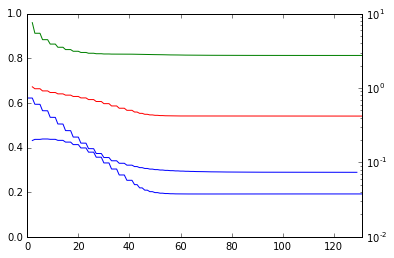

In [22]:
#create a figure
fig1, ax1 = plt.subplots(1,1)

# we create a plot with a secondary y axis using the twinx fnction
ax1b = ax1.twinx()

#create a common x axis representing the iterations
xiz=np.arange(ans[5])

#plot itlog for beta (dont plot last 2 point to create visual cue that beta belongs to left axis)
ax1.plot(xiz[0:ans[5]-2],(ans[6][0][0:ans[5]-2]))

#plot itlog for Ks (dont plot first 2 point to create visual cue that K belongs to 2nd axis)
ax1b.semilogy(xiz[0+2:ans[5]],(ans[6][1][0+2:ans[5],0]))
ax1b.semilogy(xiz[0+2:ans[5]],(ans[6][1][0+2:ans[5],1]))
ax1b.semilogy(xiz[0+2:ans[5]],(ans[6][1][0+2:ans[5],2]))


ax1.set_xlim(0,ans[5]-1)
ax1.set_ylim(0,1)


plt.show()

# As in Lecture GE1, did linear algebra make a difference here?

In [50]:
ig = iguess(Z,MODEL)
beta0=ig[0]
k0=ig[1]
# no linalg, close to solution
%timeit ELLflash_explicit(Z,beta0,k0,MODEL,False)
ans=ELLflash_explicit(Z,beta0,k0,MODEL,False)
print('converged?',ans[3],'-- 1 means yes.','to beta = ',ans[2])

# linalg, close to solution
%timeit ELLflash(Z,beta0,k0,MODEL)
ans=ELLflash(Z,beta0,k0,MODEL)
print('converged?',ans[3],'-- 1 means yes.','to beta = ',ans[2])
#approximately 1/3 ~ 1/4 the time here

100 loops, best of 3: 19 ms per loop
converged? 1 -- 1 means yes. to beta =  [[ 0.28895829]]
100 loops, best of 3: 5.08 ms per loop
converged? 1 -- 1 means yes. to beta =  [[ 0.28904542]]


# grid calc plot
as a simple idea to vary the independent variables of the system under study -- that is the overall composition
and calculate the equilibrium condition for each we propose the following grid:

In [106]:
nspace = 20

Z1 = np.linspace(0,1,nspace) # a linear grid in Z1
Z2 = np.linspace(0,1,nspace) # a linear grid in Z2

Z1[0]=1e-9
Z2[0]=1e-9


Z1[-1]=1-2e-9
Z2[-1]=1-2e-9

#linear space for z1,z2 inside [0,1]x[0,1]
rawZs = np.ndarray((nspace,nspace), dtype=object)

flags = np.zeros((nspace,nspace))

for i in range(nspace):
    for j in range(nspace):
        rawZs[i,j]=np.array([Z1[i],Z2[j],1-Z1[i]-Z2[j]]) #calculate the 3rd molar fraction, which is dependent on the previous 2
        if ( Z1[i] + Z2[j] < 1 ): # filter all points in the cartesina Z1,Z2 that meet the requirements of non-negative and summing 1 molar fractions
            flags[i,j] = 1 #auxiliar flags array help with thais fltering

Zs = rawZs[np.where(flags==1)] #valid zs - the simplex where z1+z2<=1 and z3=1-z1-z2 (conseq z1+z2+Z3=1 forall z1,z2,z3 in [0,1])

npts = Zs.shape[0] #number of valid pts

print('attempnt calculation for',npts)

Results_beta = np.zeros([npts])
Results_conv = np.zeros([npts])
Results_Z = np.zeros([npts,3])
Results_XI = np.zeros([npts,3])
Results_XII = np.zeros([npts,3])
Results_K0 = np.ndarray(npts, dtype = object)
Results_K = np.ndarray(npts, dtype = object)
Results_beta0 = np.zeros([npts])

l=0
for k in range(npts):
        
    # for each point in the grid,
    
    # calculate the initial guess
    beta0, K0 = iguess(np.array([Zs[k]]).T,MODEL)
    
    #then calculate the flash
    ans = ELLflash(np.array([Zs[k]]).T,beta0,K0,MODEL)
    
    if (0<ans[2] and 1>ans[2] and ans[3]!=0):

        Results_XI[l,:] = ans[0][0:3,0]
        Results_XII[l,:] = ans[1][0:3,0]
        Results_beta[l] = ans[2]
        Results_conv[l] = ans[3]

        Results_Z[l,:] = Zs[k]
        
        Results_beta0[l] = beta0[0,0]
        Results_K0[l] = K0
        
        Results_K[l] = Results_XII[l,:]/Results_XI[l,:]
        
        l+=1
            
print('done',l)
    
ndone=l-1

attempnt calculation for 196
done 22


* of a grid with 196 points we foundo solutions for 22 points
* lets soon see wether we tried calculations at conditions that do not have solution, or at conds that had solutions but our algorithms missed

# filter only the converged results

In [107]:
fResults_XI = Results_XI[:][np.where(Results_conv!=0)]
fResults_XII = Results_XII[:][np.where(Results_conv!=0)]
fResults_beta = Results_beta[np.where(Results_conv!=0)]
fResults_Z = Results_Z[:][np.where(Results_conv!=0)]

In [108]:
# identify the results for analysis and plotting
XI_EA=fResults_XI[:,0]
XI_W=fResults_XI[:,1]
XI_E=fResults_XI[:,2]

XII_EA=fResults_XII[:,0]
XII_W=fResults_XII[:,1]
XII_E=fResults_XII[:,2]

Z_EA=fResults_Z[:,0]
Z_W=fResults_Z[:,1]
Z_E=fResults_Z[:,2]

In [109]:
# plot mole fractions results in axis of E vs EA plot(dataEA,dataE)

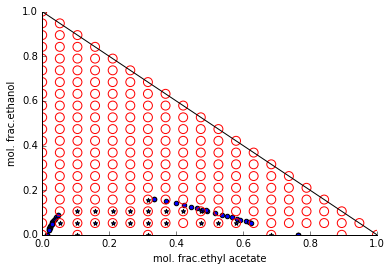

In [110]:
fig, ax = plt.subplots(1,1)

plt.axis([0,1,0,1])
    
plt.scatter(XI_EA,XI_E)    
plt.scatter(XII_EA,XII_E)    

ZS=np.zeros([npts,3])
for i in range(npts):
    ZS[i,:]=Zs[i]

plt.scatter(ZS[:,0],ZS[:,2],marker='o',s=80, facecolors='none', edgecolors='r')    
    
plt.scatter(Z_EA,Z_E,marker='*')

plt.xlabel('mol. frac.' + compNames[i_EA])
plt.ylabel('mol. frac.' + compNames[i_E])    

#UNCOMMENT THIS LINE TO PLOT THE FAILED POINT
#failedpoint= [0.42105263 , 0.52631579 , 0.05263158]
#plt.scatter(failedpoint[0],failedpoint[2],marker='d')

plt.plot([0,1],[1,0],color='k')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

plt.show()

# note that we tried flash at every open circle, but converged only at asteriscs
# outside the visible phase diagram, we sholud not have convergence because there is indeed no soltuiotn foe LLE
# however inside the phase envelope there is solution but our algorithm failed
# see discussions on that on notebook GE6

In [111]:
#sort mole fraction LEFT and RIGHT of the crit point, so we can connect the dots
# sort points arbitrariyl identified by the algorith as XI and XII into XIl XIr XIIL XIIr

X_EA_crit=.2 #approximately

XI_EAl=XI_EA[np.where(XI_EA<=X_EA_crit)]
XI_EAr=XI_EA[np.where(XI_EA>X_EA_crit)]
XII_EAl=XII_EA[np.where(XII_EA<=X_EA_crit)]
XII_EAr=XII_EA[np.where(XII_EA>X_EA_crit)]

XI_Wl=XI_W[np.where(XI_EA<=X_EA_crit)]
XI_Wr=XI_W[np.where(XI_EA>X_EA_crit)]
XII_Wl=XII_W[np.where(XII_EA<=X_EA_crit)]
XII_Wr=XII_W[np.where(XII_EA>X_EA_crit)]

XI_El=XI_E[np.where(XI_EA<=X_EA_crit)]
XI_Er=XI_E[np.where(XI_EA>X_EA_crit)]
XII_El=XII_E[np.where(XII_EA<=X_EA_crit)]
XII_Er=XII_E[np.where(XII_EA>X_EA_crit)]

In [112]:
#cooncatenate points from arbitrary XI and XII into L and R arrays,
#which actually defines the two different phases I and II

Lx = np.concatenate((XI_EAl,XII_EAl),axis=0)
Ly = np.concatenate((XI_El,XII_El),axis=0)

Rx = np.concatenate((XI_EAr,XII_EAr),axis=0)
Ry = np.concatenate((XI_Er,XII_Er),axis=0)

sLy=np.sort(Ly)
sLx=np.sort(Lx)
sRy=np.sort(Ry)
sRx=-np.sort(-Rx)


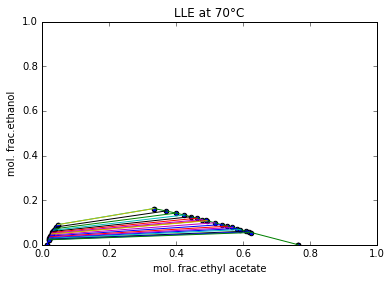

In [113]:
plt.axis([0,1,0,1])
    
plt.scatter(Lx,Ly)    
plt.scatter(Rx,Ry)    

plt.plot(sLx,sLy)
plt.plot(sRx,sRy)

# plot every calculated tieline
for i in range(0,ndone):
    plt.plot([XI_EA[i],XII_EA[i]],[XI_E[i],XII_E[i]])
    
plt.xlabel('mol. frac.' + compNames[i_EA])
plt.ylabel('mol. frac.' + compNames[i_E])    

plt.title('LLE at '+str(T-273)+'°C')    

plt.show()

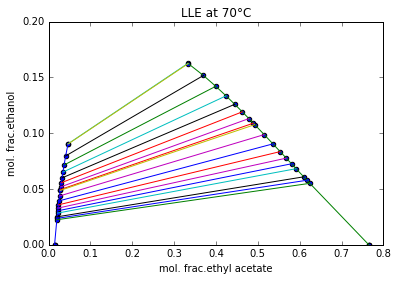

In [114]:
plt.axis([0,.8,0,.2])
    
plt.scatter(Lx,Ly)    
plt.scatter(Rx,Ry)    

plt.plot(sLx,sLy)
plt.plot(sRx,sRy)


# plot every calculated tieline
for i in range(0,ndone):
    plt.plot([XI_EA[i],XII_EA[i]],[XI_E[i],XII_E[i]])

plt.xlabel('mol. frac.' + compNames[i_EA])
plt.ylabel('mol. frac.' + compNames[i_E])    
    
plt.title('LLE at '+str(T-273)+'°C')    
    
plt.show()


In [115]:
# Warm restart GCP
MODEL = lambda x: Gamma(T,x,alpha,A)

nspace = 400

#Z0 = np.array([0.1  , 0.85 , 0.05]).T
Z0 = np.array([[0.4  , 0.6-1e-9 , 1e-9]]).T

ig = iguess(Z0,MODEL)

ans = ELLflash(Z0,ig[0],ig[1],MODEL)
print (ans)

(array([[  1.43020513e-02],
       [  9.85697948e-01],
       [  5.47056472e-10]]), array([[  7.65267420e-01],
       [  2.34732578e-01],
       [  1.42895098e-09]]), array([[ 0.51360284]]), 1, 65, 102)


# having noticed the algorithm converges on ost of the points in the first proposed grid, and being able to calculate beta, XI and XII for (theoretically) any Z
# we now proceed to a secondary objective, create a grid that will generate a figure with tielines more evenly spcaced, we dont care now for pronting values of beta, but rather only plot XI and xII to assemble the LLE envelope in the phase diagram.

* we start with a equilibrium point close to the binary line
* we proceed with variations of Z that we expect will yeld tie lines evenly spaced coming from the almost binary calculation up to close to the LLE crit point
  * the next Z shall be the middle point of the tileine from the previous Z plus a small vector in the direction perepndicular to the tieline
* we use the initial guess functionfor the frist flash
* but noticign the sequential calculations, we use a warm restart methodology, the solution of each flash is the initial guess for the next

In [116]:
nspace = 100
 
Z0 = np.array([0.4  , 0.6-3e-9 , 3e-9]) #first calculation point, aprox. binary of EA and W: Z_E = 1e-9

Zs = np.ndarray((nspace), dtype=object)

flags = np.zeros((nspace))

npts = nspace

Results_beta = np.zeros([npts])
Results_conv = np.zeros([npts])
Results_Z = np.zeros([npts,3])
Results_XI = np.zeros([npts,3])
Results_XII = np.zeros([npts,3])

Zs[0]=Z0

beta0, K0 = iguess(np.array([Zs[0]]).T,MODEL)

l=0

for k in range(nspace-1):

    try:
    
        ans = ELLflash(np.array([Zs[k]]).T,beta0,K0,MODEL)
        #succeeds:

        if (0<ans[2][0,0] and 1>ans[2][0,0] and ans[3]!=0):

            Results_XI[l,:] = ans[0][0:3,0]#np.array([ans[0][0][0],ans[0][1][0],ans[0][2][0]])
            Results_XII[l,:] = ans[1][0:3,0] #np.array([ans[1][0][0],ans[1][1][0],ans[1][2][0]])
            Results_beta[l] = ans[2]
            Results_conv[l] = ans[3]

            Results_Z[l,:] = Zs[k]

            x=Zs[k][2]
            y=Zs[k][1]            

           
            Results_XI[l,:] = ans[0][0:3,0]

            
            vec = Results_XII[l,:] - Results_XI[l,:]
            
            vm = 0.5*(Results_XII[l,:] + Results_XI[l,:])

           
            ww1=1
            ww2 = vec[2]*ww1/vec[1]

            w1 = ww1/(np.sqrt(ww1**2+ww2**2))
            w2 = ww2/(np.sqrt(ww1**2+ww2**2))
            
            xm=vm[2]
            ym=vm[1]
            d=0.01
            x=xm+w1*d
            y=ym+w2*d
            z=1-y-x
            Zs[k+1]=[z,y,x]

           
            beta0=ans[2].copy()
            K0=ans[1]/ans[0]

            l+=1
            
        #else:
            #raise ValueError

    except:
        break # after first non cinvergence, break the grid

print('done',l)
ndone=l







done 17


# filter only the converged results

In [117]:
fResults_XI = Results_XI[:][np.where(Results_conv!=0)]
fResults_XII = Results_XII[:][np.where(Results_conv!=0)]
fResults_beta = Results_beta[np.where(Results_conv!=0)]
fResults_Z = Results_Z[:][np.where(Results_conv!=0)]

In [118]:
# identify the results for analysis and plotting
XI_EA=fResults_XI[:,0]
XI_W=fResults_XI[:,1]
XI_E=fResults_XI[:,2]

XII_EA=fResults_XII[:,0]
XII_W=fResults_XII[:,1]
XII_E=fResults_XII[:,2]

Z_EA=fResults_Z[:,0]
Z_W=fResults_Z[:,1]
Z_E=fResults_Z[:,2]

In [119]:
# plot mole fractions results in axis of E vs EA plot(dataEA,dataE)

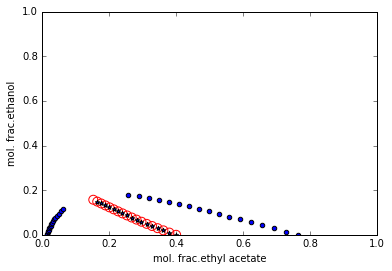

In [120]:
plt.axis([0,1,0,1])
    
plt.scatter(XI_EA,XI_E)    
plt.scatter(XII_EA,XII_E)    

ZS=np.zeros([npts,3])
for i in range(npts):
    ZS[i,:]=Zs[i]

plt.scatter(ZS[:,0],ZS[:,2],marker='o',s=80, facecolors='none', edgecolors='r')    
    
plt.scatter(Z_EA,Z_E,marker='*')

plt.xlabel('mol. frac.' + compNames[i_EA])
plt.ylabel('mol. frac.' + compNames[i_E])    

#UNCOMMENT THIS LINE TO PLOT THE FAILED POINT
#failedpoint= [0.42105263 , 0.52631579 , 0.05263158]
#plt.scatter(failedpoint[0],failedpoint[2],marker='d')

plt.show()

# note that we tried flash at every open circle, but converged only at asteriscs
# outside the visible phase diagram, we sholud not have convergence because there is indeed no soltuiotn foe LLE
# however inside the phase envelope there is solution but our algorithm failed
# see discussions on that on notebook GE6

In [121]:
#sort mole fraction LEFT and RIGHT of the crit point, so we can connect the dots
# sort points arbitrariyl identified by the algorith as XI and XII into XIl XIr XIIL XIIr

X_EA_crit=.2 #approximately

XI_EAl=XI_EA[np.where(XI_EA<=X_EA_crit)]
XI_EAr=XI_EA[np.where(XI_EA>X_EA_crit)]
XII_EAl=XII_EA[np.where(XII_EA<=X_EA_crit)]
XII_EAr=XII_EA[np.where(XII_EA>X_EA_crit)]

XI_Wl=XI_W[np.where(XI_EA<=X_EA_crit)]
XI_Wr=XI_W[np.where(XI_EA>X_EA_crit)]
XII_Wl=XII_W[np.where(XII_EA<=X_EA_crit)]
XII_Wr=XII_W[np.where(XII_EA>X_EA_crit)]

XI_El=XI_E[np.where(XI_EA<=X_EA_crit)]
XI_Er=XI_E[np.where(XI_EA>X_EA_crit)]
XII_El=XII_E[np.where(XII_EA<=X_EA_crit)]
XII_Er=XII_E[np.where(XII_EA>X_EA_crit)]

In [122]:
#cooncatenate points from arbitrary XI and XII into L and R arrays,
#which actually defines the two different phases I and II

Lx = np.concatenate((XI_EAl,XII_EAl),axis=0)
Ly = np.concatenate((XI_El,XII_El),axis=0)

Rx = np.concatenate((XI_EAr,XII_EAr),axis=0)
Ry = np.concatenate((XI_Er,XII_Er),axis=0)

sLy=np.sort(Ly)
sLx=np.sort(Lx)
sRy=np.sort(Ry)
sRx=-np.sort(-Rx)


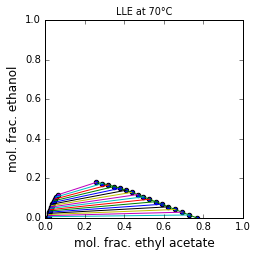

In [145]:
plt.axis([0,1,0,1])
    
plt.scatter(Lx,Ly)    
plt.scatter(Rx,Ry)    

plt.plot(sLx,sLy)
plt.plot(sRx,sRy)

# plot every calculated tieline
for i in range(0,ndone):
    plt.plot([XI_EA[i],XII_EA[i]],[XI_E[i],XII_E[i]])
    
plt.xlabel('mol. frac. ' + compNames[i_EA])
plt.ylabel('mol. frac. ' + compNames[i_E])    

plt.title('LLE at '+str(T-273)+'°C')    

plt.show()

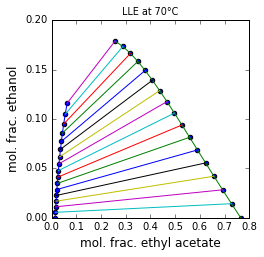

In [148]:
plt.axis([0,.8,0,.2])
    
plt.scatter(Lx,Ly)    
plt.scatter(Rx,Ry)    

plt.plot(sLx,sLy)
plt.plot(sRx,sRy)


# plot every calculated tieline
for i in range(0,ndone):
    plt.plot([XI_EA[i],XII_EA[i]],[XI_E[i],XII_E[i]])

plt.xlabel('mol. frac. ' + compNames[i_EA])
plt.ylabel('mol. frac. ' + compNames[i_E])    
    
plt.title('LLE at '+str(T-273)+'°C')    
    
plt.show()


# publication ready format for our graphical abstract

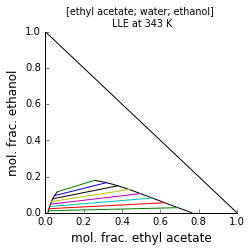

In [154]:
#bonus: some drafts for saving the fig in publication quality format

from matplotlib import rcParams as rc

fig_width = 9 / 2.54 #in inches
fig_height = 9 / 2.54 #in inches
fig_size =  [fig_width,fig_height]

#FONTS & TICKS\n",
params = {'backend': 'ps',
'axes.labelsize': 12,  #in pts
'font.size': 8, #in pts
'legend.fontsize': 8, #in pts
'xtick.labelsize': 10, #in pts
'ytick.labelsize': 10, #in pts
'text.usetex': False,
'figure.figsize': fig_size}
rc.update(params)

GAfig, GAax1 = plt.subplots(1,1)

plt.axis([0,1,0,1])
    
#plt.scatter(Lx,Ly)    
#plt.scatter(Rx,Ry)    

plt.plot(sLx,sLy,color='k')
plt.plot(sRx,sRy,color='k')


# plot every calculated tieline
for i in range(0,ndone,2):
    plt.plot([XI_EA[i],XII_EA[i]],[XI_E[i],XII_E[i]])

plt.xlabel('mol. frac. ' + compNames[i_EA])
plt.ylabel('mol. frac. ' + compNames[i_E])    
    
plt.title('[ethyl acetate; water; ethanol] \n LLE at '+str(T)+' K')    

#plt.legend()    

plt.plot([0,1],[1,0],color='k')

GAax1.spines['right'].set_visible(False)
GAax1.spines['top'].set_visible(False)
GAax1.yaxis.set_ticks_position('left')
GAax1.xaxis.set_ticks_position('bottom')


plt.tight_layout()

GAfig.savefig('fig3.png', dpi=1000)
        
plt.show() #finally show the plot. It shows in the output section of the cell if the magic command %matplotlib inline was used in the beginning of the notebook